Step1.1 Data Loading

In [221]:

#Imports
import os, sys, numpy as np, pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
np.random.seed(42)
tf.random.set_seed(42)
print("Imports OK")


Imports OK


In [222]:
# Load the dataset
train_df = pd.read_csv("/Users/poraya/Documents/AI-project/train.csv")
test_df = pd.read_csv("/Users/poraya/Documents/AI-project/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Preview dataset
train_df.head()

Train shape: (8693, 14)
Test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [223]:
# Check missing values
missing = train_df.isnull().sum().sort_values(ascending=False)
print("Missing Values:")
print(missing[missing > 0])


Missing Values:
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64


In [224]:
# Quick statistical overview
train_df.describe(include="all")


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


Step1.2 Data Cleaning

In [238]:
# clean data 
def clean_spaceship_data(df, is_train=True):
    df = df.copy()

    # Split Cabin → Deck / Num / Side
    if 'Cabin' in df.columns:
        df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
        df = df.drop(columns=['Cabin'], errors='ignore')

    # Fill Missing Values (categorical)
    for col in ['HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinSide', 'Destination', 'VIP']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0])

    # Fill Missing Values (numeric)
    for col in ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Convert boolean → int
    if 'CryoSleep' in df.columns:
        df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0})
    if 'VIP' in df.columns:
        df['VIP'] = df['VIP'].map({True: 1, False: 0})
    if is_train and 'Transported' in df.columns:
        df['Transported'] = df['Transported'].map({True: 1, False: 0})

    # Convert CabinNum to numeric
    if 'CabinNum' in df.columns:
        df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
        df['CabinNum'] = df['CabinNum'].fillna(df['CabinNum'].median())

    # Drop unnecessary columns
    df = df.drop(columns=['Name', 'PassengerId'], errors='ignore')

    # One-hot encode categorical variables
    categorical_cols = ['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide']
    existing_cats = [c for c in categorical_cols if c in df.columns]
    df = pd.get_dummies(df, columns=existing_cats, drop_first=True)

    return df

# Clean both train and test 
train_clean = clean_spaceship_data(train_df, is_train=True)
test_clean  = clean_spaceship_data(test_df,  is_train=False)

# Split X, y
X = train_clean.drop(columns=['Transported'])
y = train_clean['Transported'].values.astype(int)

print("✅ Cleaned Train Shape:", train_clean.shape)
print("✅ Cleaned Test Shape:", test_clean.shape)
print("✅ X shape:", X.shape, "y shape:", y.shape)
print("✅ Missing in Train:", train_clean.isnull().sum().sum())
print("✅ Missing in Test:", test_clean.isnull().sum().sum())

train_clean.head()

✅ Cleaned Train Shape: (8693, 22)
✅ Cleaned Test Shape: (4277, 21)
✅ X shape: (8693, 21) y shape: (8693,)
✅ Missing in Train: 0
✅ Missing in Test: 0


/var/folders/gr/pfv5w5hx4m904t97xs_9qv7m0000gn/T/ipykernel_59441/2046937614.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/var/folders/gr/pfv5w5hx4m904t97xs_9qv7m0000gn/T/ipykernel_59441/2046937614.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinNum,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,False,True,True,False,False,False,False,False,False,False
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0.0,...,False,True,False,False,False,False,True,False,False,True
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0.0,...,False,True,False,False,False,False,False,False,False,True
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,...,False,True,False,False,False,False,False,False,False,True
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,1.0,...,False,True,False,False,False,False,True,False,False,True


Step2 Train and Test split and Scaling

In [226]:
#Split features and target 
X = train_clean.drop("Transported", axis=1)
y = train_clean["Transported"]

#Train/test split (80:20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)

#Scale numerical data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete. Data ready for both GradientBoostingClassifier & Neural Network.")


X_train: (6954, 21)
X_test: (1739, 21)
y_train: (6954,)
Scaling complete. Data ready for both GradientBoostingClassifier & Neural Network.


Step3 Model 1 Simple NN (Sequential)

In [227]:
# Get input dimension
input_dim = X_train_scaled.shape[1]
print("Input dimension:", input_dim)

# Model 1: Sequential Neural Network 
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

# Compile model 
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        "accuracy",
        "mae"
       
    ]
)
model.summary()

Input dimension: 21


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early Stopping 
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=5,          
    restore_best_weights=True 
)
# Train model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=25,
    batch_size=32,
    verbose=1
)

Epoch 1/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7482 - auc: 0.8236 - loss: 0.5157 - mae: 0.3570 - val_accuracy: 0.7832 - val_auc: 0.8837 - val_loss: 0.4269 - val_mae: 0.2937
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.7880 - auc: 0.8744 - loss: 0.4385 - mae: 0.2908 - val_accuracy: 0.7993 - val_auc: 0.8934 - val_loss: 0.4049 - val_mae: 0.2737
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.7939 - auc: 0.8834 - loss: 0.4236 - mae: 0.2776 - val_accuracy: 0.8016 - val_auc: 0.8953 - val_loss: 0.3999 - val_mae: 0.2670
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.8013 - auc: 0.8847 - loss: 0.4216 - mae: 0.2751 - val_accuracy: 0.8051 - val_auc: 0.8977 - val_loss: 0.3958 - val_mae: 0.2646
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.7998 - auc: 0.8877 - loss: 0.4158 - mae: 0.2707 - val_accuracy: 0.8039 - val_auc: 0.8986 - val_loss: 0.3938 - val_mae: 0.2641
Epoch 6/25
218/218 ━━━━━━━━━━━━━

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


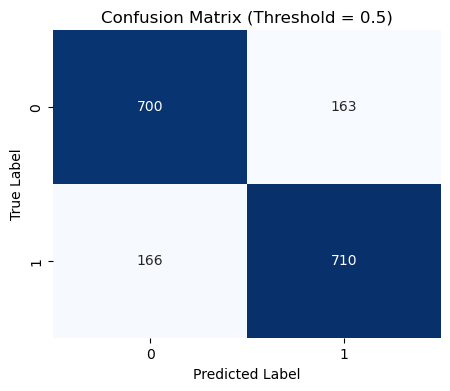


 Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0     0.8083    0.8111    0.8097       863
           1     0.8133    0.8105    0.8119       876

    accuracy                         0.8108      1739
   macro avg     0.8108    0.8108    0.8108      1739
weighted avg     0.8108    0.8108    0.8108      1739



In [229]:
# Predict probabilities (0–1)
y_pred_prob = model.predict(X_test_scaled).flatten()

# threshold = 0.5 
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report 
print("\n Classification Report (Threshold = 0.5):")
print(classification_report(y_test, y_pred, digits=4))



In [230]:
# === Evaluate model ===
test_loss, test_auc, test_acc, test_mae = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"✅ Test Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}, Loss: {test_loss:.4f}, MAE: {test_mae:.4f}")
nn_model = model


55/55 - 0s - 494us/step - accuracy: 0.8108 - auc: 0.9041 - loss: 0.3819 - mae: 0.2536
✅ Test Accuracy: 0.8108, AUC: 0.9041, Loss: 0.3819, MAE: 0.2536


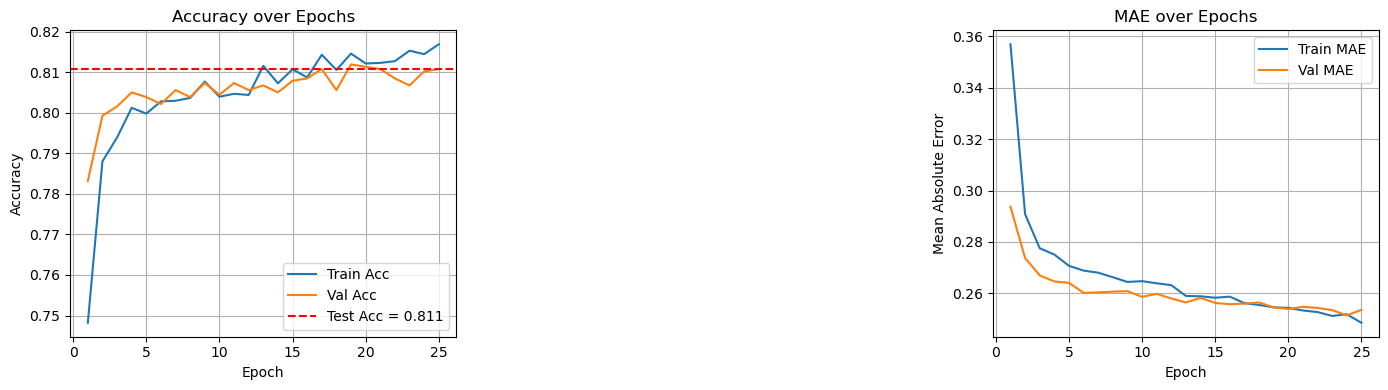

In [231]:
# === Plot Learning Curves ===
epochs = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(18,4))

# ---- Accuracy ----
plt.subplot(1,4,2)
plt.plot(epochs, history.history["accuracy"], label="Train Acc")
plt.plot(epochs, history.history["val_accuracy"], label="Val Acc")
plt.axhline(y=test_acc, color='r', linestyle='--', label=f"Test Acc = {test_acc:.3f}")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)


# ---- MAE ----
plt.subplot(1,4,4)
plt.plot(epochs, history.history["mae"], label="Train MAE")
plt.plot(epochs, history.history["val_mae"], label="Val MAE")
plt.title("MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Step4 Model GradientBoostingClassifier

In [232]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd
import seaborn as sns

SEED = 42
n_splits = 5
pred_dict = {}
gb_models = []
cv_metrics = []

X_train_full = X_train.values
y_train_full = y_train.values

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=SEED)

best_fold_idx = None
best_fold_auc_cv = -np.inf
best_val_true = None
best_val_pred = None
best_val_pred_prob = None

for fold_idx, (tr_ids, val_ids) in enumerate(sss.split(X_train_full, y_train_full), start=1):
    print(f"\n=== Fold {fold_idx} ===")

    gb = GradientBoostingClassifier(
        max_depth=7,
        max_features='sqrt',
        n_estimators=600,
        n_iter_no_change=50,
        tol=0,
        subsample=0.75,
        learning_rate=0.05,
        validation_fraction=0.2,
        verbose=0,
        random_state=SEED + fold_idx
    )

    gb.fit(X_train_full[tr_ids], y_train_full[tr_ids])

    raw_ests = gb.n_estimators_
    opt_ests = np.argmax(np.cumsum(gb.oob_improvement_)) + 1
    estop_ests = max(raw_ests - gb.n_iter_no_change, 1)

    print("Before tuning - Peak OOB cumulative improvement:", np.max(np.cumsum(gb.oob_improvement_)))

    gb = GradientBoostingClassifier(
        max_depth=7,
        max_features='sqrt',
        n_estimators=estop_ests,
        n_iter_no_change=50,
        tol=0,
        subsample=0.75,
        learning_rate=0.05,
        validation_fraction=0.2,
        verbose=0,
        random_state=SEED + fold_idx
    )

    gb.fit(X_train_full[tr_ids], y_train_full[tr_ids])

    print("After tuning - Peak OOB cumulative improvement:", np.max(np.cumsum(gb.oob_improvement_)))

    X_val = X_train_full[val_ids]
    y_val = y_train_full[val_ids]

    y_val_pred_prob = gb.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    val_acc = accuracy_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_pred_prob)
    val_loss = log_loss(y_val, y_val_pred_prob)

    print(f"Validation Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}, LogLoss: {val_loss:.4f}")

    cv_metrics.append({
        "fold": fold_idx,
        "accuracy": val_acc,
        "auc": val_auc,
        "log_loss": val_loss
    })

    pred_dict[f"gbc_{fold_idx}"] = gb.predict_proba(X_test)[:, 1]
    gb_models.append(gb)

    if val_auc > best_fold_auc_cv:
        best_fold_auc_cv = val_auc
        best_fold_idx = fold_idx
        best_val_true = y_val
        best_val_pred = y_val_pred
        best_val_pred_prob = y_val_pred_prob

if not pred_dict:
    raise RuntimeError("No predictions collected from Gradient Boosting folds")

GB_PRED_MATRIX = np.column_stack(list(pred_dict.values()))
gb_holdout_pred_prob = GB_PRED_MATRIX.mean(axis=1)

gb_cv_results = pd.DataFrame(cv_metrics)
gb_best_model = gb_models[best_fold_idx - 1]



=== Fold 1 ===
Before tuning - Peak OOB cumulative improvement: 0.9589430966456538
After tuning - Peak OOB cumulative improvement: 0.8655131538306787
Validation Accuracy: 0.7930, AUC: 0.8781, LogLoss: 0.4290

=== Fold 2 ===


/opt/anaconda3/envs/se411/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Before tuning - Peak OOB cumulative improvement: 0.9819125213339976
After tuning - Peak OOB cumulative improvement: 0.9207672352559053
Validation Accuracy: 0.8081, AUC: 0.8978, LogLoss: 0.3998

=== Fold 3 ===


/opt/anaconda3/envs/se411/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Before tuning - Peak OOB cumulative improvement: 1.0074954656004
After tuning - Peak OOB cumulative improvement: 0.942652231467044
Validation Accuracy: 0.7965, AUC: 0.8927, LogLoss: 0.4081

=== Fold 4 ===


/opt/anaconda3/envs/se411/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Before tuning - Peak OOB cumulative improvement: 0.9415547081619537
After tuning - Peak OOB cumulative improvement: 0.891186024964232
Validation Accuracy: 0.8009, AUC: 0.8957, LogLoss: 0.4033

=== Fold 5 ===


/opt/anaconda3/envs/se411/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Before tuning - Peak OOB cumulative improvement: 0.9406597186275898
After tuning - Peak OOB cumulative improvement: 0.8612660922479676
Validation Accuracy: 0.8059, AUC: 0.8960, LogLoss: 0.4019


/opt/anaconda3/envs/se411/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Gradient Boosting cross-validation metrics (StratifiedShuffleSplit):


,fold,accuracy,auc,log_loss
0,1,0.792955,0.878141,0.429003
1,2,0.808052,0.897838,0.399770
2,3,0.796549,0.892737,0.408138
3,4,0.800863,0.895728,0.403293
4,5,0.805895,0.895959,0.401854


Mean Accuracy : 0.8009
Mean AUC      : 0.8921
Mean Log Loss : 0.4084
Best fold by AUC: Fold 2 (AUC = 0.8978)


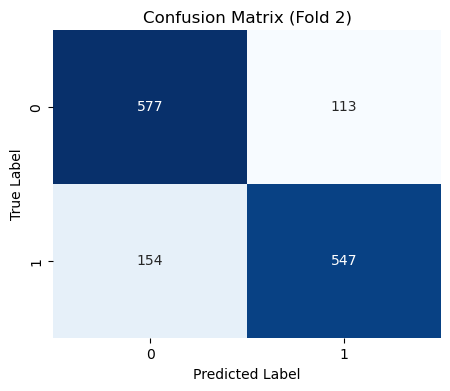


📊 Classification Report (Fold 2):
              precision    recall  f1-score   support

           0     0.7893    0.8362    0.8121       690
           1     0.8288    0.7803    0.8038       701

    accuracy                         0.8081      1391
   macro avg     0.8091    0.8083    0.8080      1391
weighted avg     0.8092    0.8081    0.8079      1391



In [233]:
# === Gradient Boosting Cross-Validation Summary ===
print("Gradient Boosting cross-validation metrics (StratifiedShuffleSplit):")
display(gb_cv_results)

print(f"Mean Accuracy : {gb_cv_results['accuracy'].mean():.4f}")
print(f"Mean AUC      : {gb_cv_results['auc'].mean():.4f}")
print(f"Mean Log Loss : {gb_cv_results['log_loss'].mean():.4f}")
print(f"Best fold by AUC: Fold {best_fold_idx} (AUC = {best_fold_auc_cv:.4f})")

cm = confusion_matrix(best_val_true, best_val_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix (Fold {best_fold_idx})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"\n📊 Classification Report (Fold {best_fold_idx}):")
print(classification_report(best_val_true, best_val_pred, digits=4))


In [234]:
# Store references for later comparisons
model_nn = nn_model
model_gb = gb_best_model


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step
🧠 Neural Network Results:
   Accuracy : 0.8108
   AUC      : 0.9041
   Log Loss : 0.3819

🌳 Gradient Boosting (CV average) Results:
   Accuracy : 0.8108
   AUC      : 0.9095
   Log Loss : 0.3754

📊 Model Comparison:


,Model,Accuracy,AUC,Log Loss
0,Neural Network,0.810811,0.904135,0.381892
1,Gradient Boosting (CV avg),0.810811,0.909503,0.375417


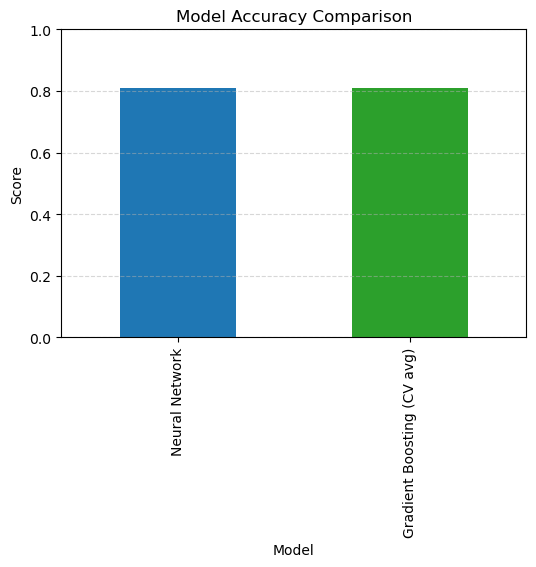

In [235]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

# === 1. Evaluate Neural Network (Sequential) ===
nn_y_pred_prob = model_nn.predict(X_test_scaled).flatten()
nn_y_pred = (nn_y_pred_prob > 0.5).astype(int)

nn_acc = accuracy_score(y_test, nn_y_pred)
nn_auc = roc_auc_score(y_test, nn_y_pred_prob)
nn_loss = log_loss(y_test, nn_y_pred_prob)

print("🧠 Neural Network Results:")
print(f"   Accuracy : {nn_acc:.4f}")
print(f"   AUC      : {nn_auc:.4f}")
print(f"   Log Loss : {nn_loss:.4f}")

# === 2. Evaluate Gradient Boosting ===
gb_cv_pred_prob = gb_holdout_pred_prob
gb_cv_pred = (gb_cv_pred_prob > 0.5).astype(int)

gb_cv_acc = accuracy_score(y_test, gb_cv_pred)
gb_cv_auc = roc_auc_score(y_test, gb_cv_pred_prob)
gb_cv_loss = log_loss(y_test, gb_cv_pred_prob)

print("\n🌳 Gradient Boosting (CV average) Results:")
print(f"   Accuracy : {gb_cv_acc:.4f}")
print(f"   AUC      : {gb_cv_auc:.4f}")
print(f"   Log Loss : {gb_cv_loss:.4f}")


# === 3. Compare side-by-side ===
import pandas as pd

compare_df = pd.DataFrame([
    {"Model": "Neural Network", "Accuracy": nn_acc, "AUC": nn_auc, "Log Loss": nn_loss},
    {"Model": "Gradient Boosting (CV avg)", "Accuracy": gb_cv_acc, "AUC": gb_cv_auc, "Log Loss": gb_cv_loss},
   
])
print("\n📊 Model Comparison:")
display(compare_df)

#Optional: Visualize comparison
import matplotlib.pyplot as plt

compare_df.set_index("Model")["Accuracy"].plot(kind="bar", figsize=(6,4), color=["#1f77b4", "#2ca02c", "#ff7f0e"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()


In [236]:

final_model = GradientBoostingClassifier(
    max_depth=7,
    max_features='sqrt',
    n_estimators=600,
    n_iter_no_change=50,
    tol=0,
    subsample=0.75,
    learning_rate=0.05,
    validation_fraction=0.2,
    verbose=0,
    random_state=42
)

final_model.fit(X, y)
print("✅ Model trained on full training data")


X_kaggle_test = test_clean.copy()

# predict
kaggle_pred_prob = final_model.predict_proba(X_kaggle_test)[:, 1]
kaggle_pred = np.round(kaggle_pred_prob).astype(bool)

print("🔹 Preview Kaggle predictions:")
print(kaggle_pred[:10])


submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],     
    "Transported": kaggle_pred                
})


submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")


submission.head()


✅ Model trained on full training data
🔹 Preview Kaggle predictions:
[ True False  True  True  True  True  True  True  True  True]
Submission file created: submission.csv


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
